# Robot Self-Modeling with Neural Radiance Fields

This notebook tries to teach a robot to build its own 3D model using only camera images and joint angles. The idea is to adapt NeRF (Neural Radiance Fields) to predict where the robot's body is in 3D space based on its joint positions.

The main challenge is that robots don't come with built-in 3D models, so they have to learn this from scratch. This approach uses a special neural network called FFKSM that combines coordinate information with joint angles to predict occupancy.

**Paper Reference**: "Teaching Robots to Build Simulations of Themselves" (Nature Machine Intelligence, 2025)

## What This Notebook Does

1. **Neural Network Setup**: Creates a positional encoder and FFKSM model
2. **Data Loading**: Uses pre-collected robot images from PyBullet simulation
3. **Training**: Learns to predict robot body shape from joint angles
4. **Visualization**: Shows 3D occupancy predictions

The key insight is using a "virtual frame" transformation that makes the learning easier by aligning coordinates with the robot's structure.

In [ ]:
import os
import time
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image
from typing import Optional, Tuple, List, Union

import torch
from torch import nn
import torch.optim as optim

try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    from tqdm.notebook import trange, tqdm
    print("Running on Google Colab - Drive mounted!")
except ImportError:
    IN_COLAB = False
    from tqdm import trange, tqdm
    print("Running locally (not on Colab)")

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Global constants
NUM_MOTOR = 4
TASK = 0
action_space = 90

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on Google Colab - Drive mounted!
Using device: cuda


## Positional Encoding for Coordinates and Joints

The network uses sine and cosine functions to encode both 3D coordinates and joint angles. This is important because neural networks struggle with raw coordinate values - they need some way to understand spatial relationships.

For 3D points, the encoding turns each coordinate into multiple frequency components. With 5 frequencies, each 3D point becomes 33 values (3 × (1 + 2×5)). Joint angles get similar treatment but only need 2D encoding since there are 4 joints but we encode them as [A2, A3] pairs.

The question is whether this encoding actually helps enough to justify the complexity. NeRF uses similar encoding because scenes can be very large, but robot bodies are much smaller and more constrained. Still, the paper shows it works better than raw coordinates.

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_input: int, n_freqs: int, log_space: bool = False):
        super().__init__()
        self.d_input = d_input
        self.n_freqs = n_freqs
        self.log_space = log_space
        self.d_output = d_input * (1 + 2 * self.n_freqs)
        self.embed_fns = [lambda x: x]

        if self.log_space:
            freq_bands = 2. ** torch.linspace(0., self.n_freqs - 1, self.n_freqs)
        else:
            freq_bands = torch.linspace(2. ** 0., 2. ** (self.n_freqs - 1), self.n_freqs)

        for freq in freq_bands:
            self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
            self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

    def forward(self, x) -> torch.Tensor:
        return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

## Free Form Kinematic Self-Model (FFKSM)

This is the main neural network that predicts robot occupancy. The key innovation is the "virtual frame" transformation that rotates coordinates based on the first two joints (A0, A1) before feeding them to the network.

**Why Virtual Frame?**
The idea is that by transforming coordinates relative to the robot's second link, the network doesn't have to learn the full kinematic chain from scratch. Joints A0 and A1 define the base orientation, so everything gets expressed relative to that.

**Network Architecture:**
- **Coordinates Encoder**: Takes virtual frame coordinates (33-dim after encoding) → 128 features
- **Kinematics Encoder**: Takes joints A2, A3 (22-dim after encoding) → 128 features  
- **Predictive Module**: Combines both (256-dim) → predicts density and visibility (2 outputs)

**Critical Issues:**
The split between A0/A1 (used for transformation) and A2/A3 (fed to network) seems arbitrary. Why not let the network learn all joint relationships? Also, the virtual frame assumes the robot has a specific kinematic structure that might not generalize.

The dual output (density + visibility) is interesting but adds complexity. Density predicts occupancy, visibility weights it. But are both really needed, or is this just making the model bigger without clear benefit?

In [ ]:
def transform_to_virtual(points: torch.Tensor, ang0: torch.Tensor, ang1: torch.Tensor) -> torch.Tensor:
    device = points.device
    original_shape = points.shape

    # Flatten to (N, 3) for transformation
    if points.dim() == 3:
        points_flat = points.reshape(-1, 3)
    else:
        points_flat = points

    # Construct R_yaw(A0)^T (rotation around Z-axis, transposed)
    cos_a0 = torch.cos(ang0)
    sin_a0 = torch.sin(ang0)
    R_yaw_T = torch.tensor([
        [cos_a0,  sin_a0, 0.0],
        [-sin_a0, cos_a0, 0.0],
        [0.0,     0.0,    1.0]
    ], dtype=points.dtype, device=device)

    # Construct R_pitch(A1)^T (rotation around Y-axis, transposed)
    cos_a1 = torch.cos(ang1)
    sin_a1 = torch.sin(ang1)
    R_pitch_T = torch.tensor([
        [cos_a1,  0.0, sin_a1],
        [0.0,     1.0, 0.0],
        [-sin_a1, 0.0, cos_a1]
    ], dtype=points.dtype, device=device)

    points_transformed = points_flat @ R_pitch_T.T  # (N, 3)
    points_transformed = points_transformed @ R_yaw_T.T  # (N, 3)

    # Reshape back to original shape
    if len(original_shape) == 3:
        points_transformed = points_transformed.reshape(original_shape)

    return points_transformed


class FFKSM(nn.Module):
    def __init__(self, n_freqs: int = 5, d_filter: int = 128, output_size: int = 2):
        super(FFKSM, self).__init__()

        self.n_freqs = n_freqs
        self.d_filter = d_filter

        self.coord_input_dim = 3 * (1 + 2 * n_freqs)
        self.kinematic_input_dim = 2 * (1 + 2 * n_freqs)

        self.coord_encoder_pe = PositionalEncoder(d_input=3, n_freqs=n_freqs, log_space=True)
        self.kinematic_encoder_pe = PositionalEncoder(d_input=2, n_freqs=n_freqs, log_space=True)

        self.coord_encoder = nn.Sequential(
            nn.Linear(self.coord_input_dim, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_filter),
        )

        self.kinematic_encoder = nn.Sequential(
            nn.Linear(self.kinematic_input_dim, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_filter),
        )

        self.predictive_module = nn.Sequential(
            nn.Linear(d_filter * 2, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_filter // 4),
            nn.ReLU(),
            nn.Linear(d_filter // 4, output_size),
        )

    def forward(self, points: torch.Tensor, joint_angles: torch.Tensor) -> torch.Tensor:
        if joint_angles.dim() == 1:
            ang0, ang1, ang2, ang3 = joint_angles[0], joint_angles[1], joint_angles[2], joint_angles[3]
        else:
            ang0, ang1, ang2, ang3 = joint_angles[0, 0], joint_angles[0, 1], joint_angles[0, 2], joint_angles[0, 3]

        points_virtual = transform_to_virtual(points, ang0, ang1)

        encoded_coords = self.coord_encoder_pe(points_virtual)
        kinematic_input = torch.stack([ang2, ang3]).unsqueeze(0).expand(points.shape[0], -1)
        kinematic_input = kinematic_input.to(points.device)
        encoded_kinematics = self.kinematic_encoder_pe(kinematic_input)

        coord_features = self.coord_encoder(encoded_coords)
        kinematic_features = self.kinematic_encoder(encoded_kinematics)

        fused_features = torch.cat([coord_features, kinematic_features], dim=-1)  # (batch, 256)
        output = self.predictive_module(fused_features)  # (batch, 2)

        return output


# Backward compatibility alias
FBV_SM = FFKSM


def init_ffksm_model(pretrained_model_pth: str = None, lr: float = 1e-5,
                     n_freqs: int = 5, d_filter: int = 128, output_size: int = 2):
    model = FFKSM(n_freqs=n_freqs, d_filter=d_filter, output_size=output_size)
    model.to(device)

    if pretrained_model_pth is not None:
        model.load_state_dict(torch.load(pretrained_model_pth + "best_model.pt",
                                         map_location=torch.device(device)))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"FFKSM Model initialized:")
    print(f"  - Positional encoding frequencies: {n_freqs}")
    print(f"  - Coordinate input dim: {model.coord_input_dim}")
    print(f"  - Kinematic input dim: {model.kinematic_input_dim}")
    print(f"  - Hidden dim: {d_filter}")
    print(f"  - Total parameters: {total_params:,}")
    print(f"  - Trainable parameters: {trainable_params:,}")

    return model, optimizer

## Coordinate Transformations and Virtual Frame

These functions handle converting between different coordinate frames. The key idea is the "virtual frame" transformation that rotates 3D points based on the robot's base joints.

**Why This Matters:**
In standard NeRF, all coordinates are in world frame. But for robots, it makes more sense to think about points relative to the robot's body. The virtual frame aligns coordinates with the robot's second link, which should make learning easier.

**Technical Details:**
- Points get transformed using inverse rotations: X' = R_yaw(A0)ᵀ × R_pitch(A1)ᵀ × X
- This is equivalent to rotating the coordinate system by -A0 around Z and -A1 around Y
- The transformation is applied before positional encoding

**Critical Analysis:**
Is this transformation actually helping? The paper claims it reduces the learning burden, but it also adds complexity. Why not let the network learn the full kinematic relationships from data? The virtual frame assumes specific joint semantics that might not be universal.

In [ ]:
def rot_X(th: float) -> np.ndarray:
    return np.array([
        [1, 0, 0, 0],
        [0, np.cos(th), -np.sin(th), 0],
        [0, np.sin(th), np.cos(th), 0],
        [0, 0, 0, 1]
    ])

def rot_Y(th: float) -> np.ndarray:
    return np.array([
        [np.cos(th), 0, -np.sin(th), 0],
        [0, 1, 0, 0],
        [np.sin(th), 0, np.cos(th), 0],
        [0, 0, 0, 1]
    ])

def rot_Z(th: float) -> np.ndarray:
    return np.array([
        [np.cos(th), -np.sin(th), 0, 0],
        [np.sin(th), np.cos(th), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def transition_matrix_torch(label: str, value: torch.Tensor) -> torch.Tensor:
    matrix = torch.eye(4, dtype=torch.float32)

    if label == "rot_x":
        matrix[1, 1] = torch.cos(value)
        matrix[1, 2] = -torch.sin(value)
        matrix[2, 1] = torch.sin(value)
        matrix[2, 2] = torch.cos(value)
    elif label == "rot_y":
        matrix[0, 0] = torch.cos(value)
        matrix[0, 2] = -torch.sin(value)
        matrix[2, 0] = torch.sin(value)
        matrix[2, 2] = torch.cos(value)
    elif label == "rot_z":
        matrix[0, 0] = torch.cos(value)
        matrix[0, 1] = -torch.sin(value)
        matrix[1, 0] = torch.sin(value)
        matrix[1, 1] = torch.cos(value)

    return matrix

def pts_trans_matrix(theta, phi, no_inverse=False):
    w2c = transition_matrix_torch("rot_z", -theta / 180. * torch.pi)
    w2c = transition_matrix_torch("rot_y", -phi / 180. * torch.pi) @ w2c
    if not no_inverse:
        w2c = torch.inverse(w2c)
    return w2c

def pts_trans_matrix_numpy(theta, phi, no_inverse=False):
    w2c = rot_Z(-theta / 180. * np.pi)
    w2c = np.dot(rot_Y(-phi / 180. * np.pi), w2c)
    if no_inverse == False:
        w2c = np.linalg.inv(w2c)
    return w2c

## Image Preprocessing Helper

The `green_black` function masks out green pixels from images by converting them to white. It looks for pixels where the green channel is high (100-255) and replaces them. This could be useful if the simulation sometimes renders with a green background, though the current notebook doesn't use this function in the main pipeline.

In [ ]:
def green_black(img):
    img = np.array(img)
    mask = cv2.inRange(img[..., 1], 100, 255)
    img[mask > 0] = (255, 255, 255)
    return img

## Ray Generation and Volume Sampling

This section generates camera rays and samples 3D points along them for volume rendering. It's similar to NeRF but adapted for robot self-modeling.

**How It Works:**
- Camera rays are generated from a pinhole camera model with known focal length
- Points are sampled along each ray using stratified sampling (not uniform)
- Optional camera view transformation for different viewpoints

**Key Parameters:**
- 64 samples per ray (n_samples)
- Near/far clipping planes at 0.6 and 1.4 meters
- 100×100 pixel camera resolution

**Critical Issues:**
The camera is fixed in this setup, so the model only learns from one viewpoint. Real robots need to work from any camera angle. Also, 64 samples per ray is quite low compared to NeRF's typical 128-256 samples - this might limit accuracy.

In [ ]:
def get_rays(height: int, width: int, focal_length: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    i, j = torch.meshgrid(
        torch.arange(width, dtype=torch.float32),
        torch.arange(height, dtype=torch.float32),
        indexing='ij')

    directions = torch.stack([(i - width * .5) / focal_length,
                              -(j - height * .5) / focal_length,
                              -torch.ones_like(i)], dim=-1)

    rays_d = directions
    rays_o = torch.from_numpy(np.asarray([1, 0, 0], dtype=np.float32)).expand(directions.shape)

    rays_d_clone = rays_d.clone()
    rays_d[..., 0], rays_d[..., 2] = rays_d_clone[..., 2].clone(), rays_d_clone[..., 0].clone()

    rotation_matrix = torch.tensor([[1, 0, 0],
                                    [0, -1, 0],
                                    [0, 0, -1]])
    rotation_matrix = rotation_matrix[None, None].to(rays_d)

    rays_d = torch.matmul(rays_d, rotation_matrix)
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)
    return rays_o, rays_d

def sample_stratified(rays_o: torch.Tensor, rays_d: torch.Tensor, arm_angle: torch.Tensor,
                     near: float, far: float, n_samples: int,
                     perturb: Optional[bool] = True, inverse_depth: bool = False,
                     view_theta: float = 0.0, view_phi: float = 0.0) -> Tuple[torch.Tensor, torch.Tensor]:
    t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
    if not inverse_depth:
        x_vals = near * (1. - t_vals) + far * (t_vals)
    else:
        x_vals = 1. / (1. / near * (1. - t_vals) + 1. / far * (t_vals))

    if perturb:
        mids = .5 * (x_vals[1:] + x_vals[:-1])
        upper = torch.concat([mids, x_vals[-1:]], dim=-1)
        lower = torch.concat([x_vals[:1], mids], dim=-1)
        t_rand = torch.rand([n_samples], device=x_vals.device)
        x_vals = lower + (upper - lower) * t_rand
    x_vals = x_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

    pts = rays_o[..., None, :] + rays_d[..., None, :] * x_vals[..., :, None]

    # Use fixed view angles (0, 0) since camera is stationary in new data format
    pose_matrix = pts_trans_matrix(torch.tensor(view_theta), torch.tensor(view_phi))
    pose_matrix = pose_matrix.to(pts)
    transformation_matrix = pose_matrix[:3, :3]

    pts = torch.matmul(pts, transformation_matrix)

    return pts, x_vals

## Volume Rendering Functions

These functions convert the network's density predictions into 2D images through volume rendering. The idea is to accumulate density along each camera ray to predict how much "stuff" (robot body) is visible.

**Different Rendering Modes:**
- **OM (Occupancy Map)**: Simple density accumulation, predicts occupancy
- **VR (Volume Rendering)**: Includes distance weighting for more accurate rendering
- **VRAT (Volume Rendering with Alpha Transmittance)**: Full volumetric rendering with proper alpha compositing

**Dual Output Issue:**
The network predicts both "density" and "visibility" but the rendering functions don't always use both clearly. Density seems to be the main occupancy signal, while visibility might be an attempt to model transparency or confidence.

**Critical Analysis:**
Volume rendering is computationally expensive - each image requires thousands of network evaluations. For robot self-modeling, do we really need full volumetric rendering, or would simpler occupancy prediction work? The paper claims this approach is necessary, but the computational cost is high.

In [ ]:
def OM_rendering(raw: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 1]))
    rgb_each_point = alpha * raw[..., 0]
    render_img = torch.sum(rgb_each_point, dim=1)
    return render_img, alpha

def OM_rendering_split_output(raw):
    alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 1]))
    rgb_each_point = alpha * raw[..., 0]
    render_img = torch.sum(rgb_each_point, dim=1)
    visibility = raw[..., 0]
    return render_img, alpha, visibility

def VR_rendering(raw: torch.Tensor, x_vals: torch.Tensor, rays_d: torch.Tensor,
                raw_noise_std: float = 0.0, white_bkgd: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
    dense = 1.0 - torch.exp(-nn.functional.relu(raw[..., 0]))
    render_img = torch.sum(dense, dim=1)
    return render_img, dense

def VRAT_rendering(raw: torch.Tensor, x_vals: torch.Tensor, rays_d: torch.Tensor,
                  raw_noise_std: float = 0.0, white_bkgd: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
    dists = x_vals[..., 1:] - x_vals[..., :-1]
    dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1).to(device)
    rays_d = rays_d.to(device)
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)
    alpha_dense = 1.0 - torch.exp(-nn.functional.relu(raw[..., 0]) * dists)
    render_img = torch.sum(alpha_dense, dim=1)
    return render_img, alpha_dense

def prepare_chunks_ffksm(points: torch.Tensor, joint_angles: torch.Tensor,
                         chunksize: int = 2 ** 14) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    points = points.reshape((-1, 3))
    chunks = []
    for i in range(0, points.shape[0], chunksize):
        chunk_points = points[i:i + chunksize]
        chunks.append((chunk_points, joint_angles))
    return chunks

def model_forward_ffksm(rays_o: torch.Tensor, rays_d: torch.Tensor, near: float, far: float,
                        model: nn.Module, arm_angle: torch.Tensor, DOF: int = 4,
                        chunksize: int = 2 ** 15, n_samples: int = 64, output_flag: int = 0):
    query_points, z_vals = sample_stratified(rays_o, rays_d, arm_angle, near, far,
                                              n_samples=n_samples, view_theta=0.0, view_phi=0.0)

    if len(arm_angle) == DOF:
        joint_angles_rad = (arm_angle / 180.0 * np.pi).to(device)
    else:
        joint_angles_rad = (arm_angle[2:2+DOF] / 180.0 * np.pi).to(device)

    original_shape = query_points.shape
    query_points_flat = query_points.reshape(-1, 3)

    chunks = prepare_chunks_ffksm(query_points_flat, joint_angles_rad, chunksize=chunksize)
    predictions = []

    for chunk_points, chunk_angles in chunks:
        chunk_points = chunk_points.to(device)
        pred = model(chunk_points, chunk_angles)
        predictions.append(pred)

    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(original_shape[:2]) + [raw.shape[-1]])

    # Apply rendering based on output_flag
    if output_flag == 0:
        rgb_map, rgb_each_point = OM_rendering(raw)
    elif output_flag == 1:
        rgb_map, rgb_each_point = VR_rendering(raw, z_vals, rays_d)
    elif output_flag == 2:
        rgb_map, rgb_each_point = VRAT_rendering(raw, z_vals, rays_d)
    elif output_flag == 3:
        rgb_map, rgb_each_point, visibility = OM_rendering_split_output(raw)
        return rgb_map, query_points, rgb_each_point, visibility

    outputs = {
        'rgb_map': rgb_map,
        'rgb_each_point': rgb_each_point,
        'query_points': query_points
    }

    return outputs


# Backward compatibility: alias for old code
model_forward = model_forward_ffksm


# Legacy function for backward compatibility with old FBV_SM model
def model_forward_legacy(rays_o: torch.Tensor, rays_d: torch.Tensor, near: float, far: float,
                         model: nn.Module, arm_angle: torch.Tensor, DOF: int,
                         chunksize: int = 2 ** 15, n_samples: int = 64, output_flag: int = 0):
    query_points, z_vals = sample_stratified(rays_o, rays_d, arm_angle, near, far,
                                              n_samples=n_samples, view_theta=0.0, view_phi=0.0)

    if len(arm_angle) == DOF:
        joint_angles = arm_angle / 180 * np.pi
    else:
        joint_angles = arm_angle[2:2+DOF] / 180 * np.pi

    if DOF > 0:
        model_input = torch.cat((query_points, joint_angles.repeat(list(query_points.shape[:2]) + [1])), dim=-1)
    else:
        model_input = query_points

    points = model_input.reshape((-1, model_input.shape[-1]))
    batches = [points[i:i + chunksize] for i in range(0, points.shape[0], chunksize)]
    predictions = []
    for batch in batches:
        batch = batch.to(device)
        predictions.append(model(batch))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    if output_flag == 0:
        rgb_map, rgb_each_point = OM_rendering(raw)
    elif output_flag == 1:
        rgb_map, rgb_each_point = VR_rendering(raw, z_vals, rays_d)
    elif output_flag == 2:
        rgb_map, rgb_each_point = VRAT_rendering(raw, z_vals, rays_d)
    elif output_flag == 3:
        rgb_map, rgb_each_point, visibility = OM_rendering_split_output(raw)
        return rgb_map, query_points, rgb_each_point, visibility

    outputs = {
        'rgb_map': rgb_map,
        'rgb_each_point': rgb_each_point,
        'query_points': query_points
    }

    return outputs

## Camera and Query Configuration

This section sets up camera parameters and query functions for model inference. The camera sits at 1 meter distance with near/far clipping at 0.6 and 1.4 meters. Image resolution is 100×100 pixels with a focal length of 130.25.

The `query_models` and `query_models_separated_outputs` functions handle model inference after training. They generate rays, run the forward pass, and extract 3D occupancy points by thresholding the density predictions. Points with density above 0.4 or visibility above 0.25 are considered part of the robot.

These functions are mainly used for visualization and evaluation, not during training. They let us see what 3D shape the model predicts for a given joint configuration.

In [ ]:
cam_dist = 1.0
nf_size = 0.4
near, far = cam_dist - nf_size, cam_dist + nf_size
pxs = 100
height = pxs
width = pxs
focal = 130.2545
chunksize = 2 ** 20

def query_models_separated_outputs(angle, model, DOF, n_samples=64):
    rays_o, rays_d = get_rays(height, width, torch.tensor(focal))
    rays_o = rays_o.reshape([-1, 3]).to(device)
    rays_d = rays_d.reshape([-1, 3]).to(device)

    angle_tensor = angle.to(device)
    rgb_map, query_points, density, visibility = model_forward(
        rays_o, rays_d, near, far, model, angle_tensor, DOF,
        chunksize=chunksize, n_samples=n_samples, output_flag=3)

    all_points = query_points.reshape(-1, 3)
    rgb_each_point_density = density.reshape(-1)
    weight_visibility = visibility * density
    rgb_each_point_visibility = weight_visibility.reshape(-1)

    # Use fixed view angles (0, 0) for camera transformation
    pose_matrix_tensor = pts_trans_matrix(torch.tensor(0.0), torch.tensor(0.0), no_inverse=False).to(device)
    all_points_xyz = torch.cat((all_points, torch.ones((len(all_points), 1)).to(device)), dim=1)
    all_points_xyz = torch.matmul(pose_matrix_tensor, all_points_xyz.T).T[:, :3]

    mask1 = torch.where(rgb_each_point_density > 0.4, rgb_each_point_density, torch.zeros_like(rgb_each_point_density))
    occ_points_xyz_density = all_points_xyz[mask1.bool()]

    mask2 = torch.where(rgb_each_point_visibility > 0.25, rgb_each_point_visibility, torch.zeros_like(rgb_each_point_visibility))
    occ_points_xyz_visibility = all_points_xyz[mask2.bool() & mask1.bool()]

    return occ_points_xyz_density, occ_points_xyz_visibility

def query_models(angle, model, DOF, mean_ee=False, n_samples=64):
    rays_o, rays_d = get_rays(height, width, torch.tensor(focal))
    rays_o = rays_o.reshape([-1, 3]).to(device)
    rays_d = rays_d.reshape([-1, 3]).to(device)

    angle_tensor = angle.to(device)
    outputs = model_forward(rays_o, rays_d, near, far, model, angle_tensor, DOF,
                           chunksize=chunksize, n_samples=n_samples)

    all_points = outputs["query_points"].reshape(-1, 3)
    rgb_each_point = outputs["rgb_each_point"].reshape(-1)

    # Use fixed view angles (0, 0) for camera transformation
    pose_matrix_tensor = pts_trans_matrix(torch.tensor(0.0), torch.tensor(0.0), no_inverse=False).to(device)
    all_points_xyz = torch.cat((all_points, torch.ones((len(all_points), 1)).to(device)), dim=1)
    all_points_xyz = torch.tensor(all_points_xyz, dtype=torch.float32)
    all_points_xyz = torch.matmul(pose_matrix_tensor, all_points_xyz.T).T[:, :3]

    mask = torch.where(rgb_each_point > 0.08, rgb_each_point, torch.zeros_like(rgb_each_point))
    unmasked_occ_points_xyz = all_points_xyz[mask.bool()]

    occ_points_xyz = all_points_xyz * mask.unsqueeze(-1)
    occ_point_center_xyz = occ_points_xyz.sum(dim=0) / mask.sum()

    if mean_ee:
        return occ_point_center_xyz
    else:
        return unmasked_occ_points_xyz

## Model Query and Initialization Functions

These functions handle querying the trained model for occupancy predictions and initializing new models for training.

**Query Functions:**
- `query_models`: Returns 3D points where the model predicts the robot body is present
- `query_models_separated_outputs`: Returns both density and visibility predictions separately

**Initialization:**
The `init_models` function creates either the new FFKSM architecture or falls back to the older FBV_SM for backward compatibility with old checkpoints.

The thresholds for occupancy detection (0.4 for density, 0.25 for visibility) are hardcoded, which might not be optimal for all configurations. These values determine what gets classified as "robot" vs "empty space."

In [ ]:
def crop_center(img: torch.Tensor, frac: float = 0.5) -> torch.Tensor:
    h_offset = round(img.shape[0] * (frac / 2))
    w_offset = round(img.shape[1] * (frac / 2))
    return img[h_offset:-h_offset, w_offset:-w_offset]


def init_models(d_input=None, d_filter: int = 128, pretrained_model_pth: str = None,
                lr: float = 5e-4, output_size: int = 2,
                FLAG_PositionalEncoder: bool = True, n_freqs: int = 5,
                use_ffksm: bool = True):
    if use_ffksm:
        model = FFKSM(n_freqs=n_freqs, d_filter=d_filter, output_size=output_size)
        model.to(device)

        if pretrained_model_pth is not None:
            model.load_state_dict(torch.load(pretrained_model_pth + "best_model.pt",
                                             map_location=torch.device(device)))

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Print model info
        total_params = sum(p.numel() for p in model.parameters())
        print(f"FFKSM Model initialized:")
        print(f"  - PE frequencies: {n_freqs}, Coord dim: {model.coord_input_dim}, Kin dim: {model.kinematic_input_dim}")
        print(f"  - Hidden dim: {d_filter}, Total params: {total_params:,}")
    else:
        # Legacy FBV_SM architecture (for old checkpoints)
        if FLAG_PositionalEncoder:
            encoder = PositionalEncoder(d_input, n_freqs=n_freqs, log_space=True)

            # Create legacy model with old interface
            class LegacyFBV_SM(nn.Module):
                def __init__(self, encoder, d_input, d_filter, output_size):
                    super().__init__()
                    self.encoder = encoder
                    n_freqs = encoder.n_freqs
                    pos_encoder_d = (n_freqs * 2 + 1) * 3
                    cmd_encoder_d = (n_freqs * 2 + 1) * (d_input - 3)

                    self.pos_encoder = nn.Sequential(
                        nn.Linear(pos_encoder_d, d_filter), nn.ReLU(),
                        nn.Linear(d_filter, d_filter))
                    self.cmd_encoder = nn.Sequential(
                        nn.Linear(cmd_encoder_d, d_filter), nn.ReLU(),
                        nn.Linear(d_filter, d_filter))
                    self.feed_forward = nn.Sequential(
                        nn.Linear(d_filter * 2, d_filter), nn.ReLU(),
                        nn.Linear(d_filter, d_filter // 4))
                    self.output = nn.Linear(d_filter // 4, output_size)

                def forward(self, x):
                    x_pos = self.encoder(x[:, :3])
                    x_cmd = self.encoder(x[:, 3:])
                    x_pos = self.pos_encoder(x_pos)
                    x_cmd = self.cmd_encoder(x_cmd)
                    x = self.feed_forward(torch.cat((x_pos, x_cmd), dim=1))
                    return self.output(x)

            model = LegacyFBV_SM(encoder, d_input, d_filter, output_size)
        else:
            raise ValueError("Non-PE models not supported. Use use_ffksm=True for new models.")

        model.to(device)
        if pretrained_model_pth is not None:
            model.load_state_dict(torch.load(pretrained_model_pth + "best_model.pt",
                                             map_location=torch.device(device)))
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print(f"Legacy FBV_SM Model: {sum(p.numel() for p in model.parameters()):,} params")

    return model, optimizer

Loading data from: /content/drive/MyDrive/robot_self_modelling/data/sim_data/sim_data_robo1_lorenz_colab_2000.npz
File exists: True

Original angles shape: (2000, 4)
Detected NEW format: [j1, j2, j3, j4] - 4 joint angles only
Normalizing images from [0, 255] to [0, 1]

Loaded 2000 images.
Image range: [0.000, 1.000]
Data shape - Images: (2000, 100, 100), Angles: (2000, 4)
Focal length: 130.2545

Angles sample (first row): [2.27778966 2.83387793 2.01527597 1.94456502]
Angles range per column:
  Column 0: min=-36.20, max=40.80
  Column 1: min=-45.77, max=53.21
  Column 2: min=-33.00, max=36.52
  Column 3: min=1.91, max=70.43

Training samples: 1600, Validation samples: 400
Image dimensions: 100x100
Data format: new (model_forward will handle this automatically)


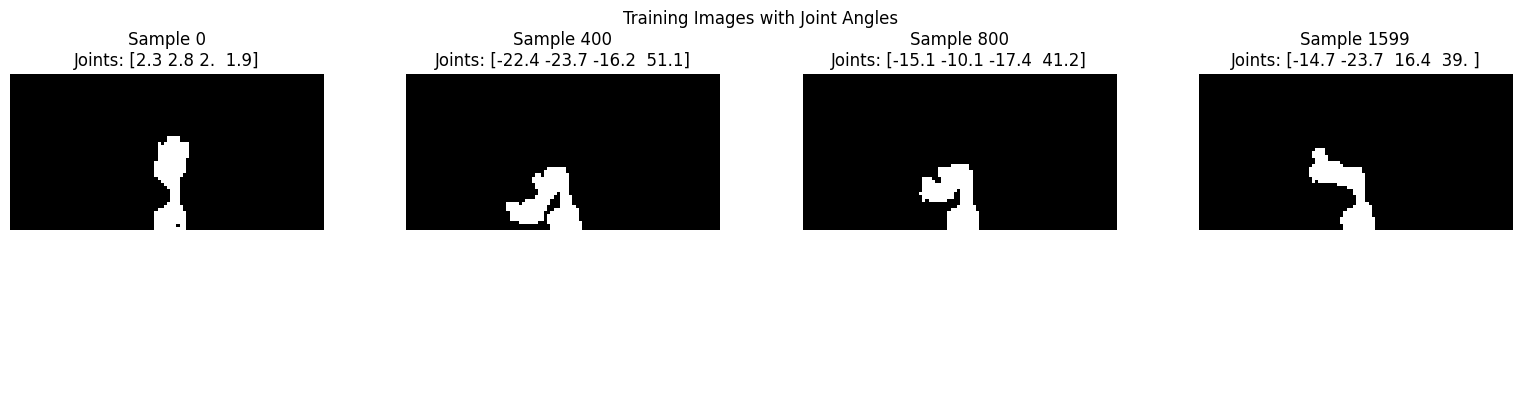

In [ ]:
DOF = 4
robotid = 1
sim_real = 'sim'
arm_ee = 'ee'
seed_num = 69
tr = 0.8

np.random.seed(seed_num)
random.seed(seed_num)
torch.manual_seed(seed_num)

# Load data - try local path first, then Colab path
if IN_COLAB:
    DATA_PATH = '/content/drive/MyDrive/robot_self_modelling/data/sim_data/sim_data_robo1_lorenz_colab_2000.npz'
else:
    # Local path - use absolute path
    import os
    base_dir = r'c:\Users\Askeladd\Desktop\MLDM 3\robot_self_modelling'
    DATA_PATH = os.path.join(base_dir, 'data', 'sim_data', 'sim_data_robo1_lorenz_colab_2000.npz')

print(f"Loading data from: {DATA_PATH}")
print(f"File exists: {os.path.exists(DATA_PATH)}")

npz_data = np.load(DATA_PATH)
data = {
    'images': npz_data['images'],
    'angles': npz_data['angles'],
    'focal': npz_data['focal']
}

# Check angles format and handle accordingly
print(f"\nOriginal angles shape: {data['angles'].shape}")
if data['angles'].shape[1] == 4:
    print("Detected NEW format: [j1, j2, j3, j4] - 4 joint angles only")
    # No conversion needed - angles are already in the correct format
    DATA_FORMAT = "new"
elif data['angles'].shape[1] == 6:
    print("Detected OLD format: [view_theta, view_phi, j1, j2, j3, j4]")
    DATA_FORMAT = "old"
else:
    raise ValueError(f"Unexpected angles shape: {data['angles'].shape[1]} columns")

# Ensure images are in the correct format (e.g., grayscale, float32)
if data['images'].ndim == 4 and data['images'].shape[-1] == 1:
    data['images'] = data['images'].squeeze(axis=-1)
elif data['images'].ndim == 4 and data['images'].shape[-1] == 3:
    print("WARNING: Loaded images are RGB. Converting to grayscale.")
    data['images'] = np.mean(data['images'], axis=-1)

# Normalize images to [0, 1] if not already
if data['images'].max() > 1.0:
    print(f"Normalizing images from [0, {data['images'].max():.0f}] to [0, 1]")
    data['images'] = data['images'].astype(np.float32) / 255.0

select_data_amount = len(data['angles'])

print(f"\nLoaded {len(data['images'])} images.")
print(f"Image range: [{data['images'].min():.3f}, {data['images'].max():.3f}]")
print(f"Data shape - Images: {data['images'].shape}, Angles: {data['angles'].shape}")
print(f"Focal length: {data['focal']}")

# Display angle statistics
print(f"\nAngles sample (first row): {data['angles'][0]}")
print(f"Angles range per column:")
for col in range(data['angles'].shape[1]):
    print(f"  Column {col}: min={data['angles'][:, col].min():.2f}, max={data['angles'][:, col].max():.2f}")

num_raw_data = len(data["angles"])
sample_id = list(range(num_raw_data))

focal_tensor = torch.from_numpy(data['focal'].astype('float32'))
training_img = torch.from_numpy(data['images'][sample_id[:int(select_data_amount * tr)]].astype('float32'))
training_angles = torch.from_numpy(data['angles'][sample_id[:int(select_data_amount * tr)]].astype('float32'))
testing_img = torch.from_numpy(data['images'][sample_id[int(select_data_amount * tr):]].astype('float32'))
testing_angles = torch.from_numpy(data['angles'][sample_id[int(select_data_amount * tr):]].astype('float32'))

train_amount = len(training_angles)
valid_amount = len(testing_angles)

height, width = training_img.shape[1:3]
print(f"\nTraining samples: {train_amount}, Validation samples: {valid_amount}")
print(f"Image dimensions: {height}x{width}")
print(f"Data format: {DATA_FORMAT} (model_forward will handle this automatically)")

# Prepare validation visualization samples
max_pic_save = 6
start_idx = int(select_data_amount * tr)
end_idx = start_idx + max_pic_save

valid_img_visual_stack = data['images'][sample_id[start_idx:end_idx]]
if valid_img_visual_stack.ndim == 3:
    valid_img_visual = np.hstack(valid_img_visual_stack)
elif valid_img_visual_stack.ndim == 4:
    valid_img_visual = np.hstack([img.squeeze() if img.ndim > 2 else img for img in valid_img_visual_stack])
else:
    valid_img_visual = valid_img_visual_stack[0]

valid_angle = data['angles'][sample_id[start_idx:end_idx]]
valid_img_visual = np.dstack((valid_img_visual, valid_img_visual, valid_img_visual))

# Show sample images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sample_indices = [0, train_amount//4, train_amount//2, train_amount-1]
for i, ax in enumerate(axes):
    idx = sample_indices[i] if sample_indices[i] < train_amount else train_amount - 1
    img_to_show = training_img[idx].numpy()
    if img_to_show.ndim == 3 and img_to_show.shape[-1] == 1:
        img_to_show = img_to_show.squeeze(-1)
    ax.imshow(img_to_show, cmap='gray')
    # Show joint angles (handle both formats)
    if DATA_FORMAT == "new":
        joint_str = training_angles[idx].numpy().round(1)
    else:
        joint_str = training_angles[idx, 2:].numpy().round(1)
    ax.set_title(f'Sample {idx}\nJoints: {joint_str}')
    ax.axis('off')
plt.suptitle('Training Images with Joint Angles')
plt.tight_layout()
plt.show()

## Training Configuration and Hyperparameters

Before running the training loop, I need to set up the model with specific hyperparameters. The paper uses:
- 5 positional encoding frequencies (n_freqs=5)
- 128 hidden units per layer (d_filter=128)
- Learning rate 5e-4
- Adam optimizer

These choices aren't well justified in the paper. Is 128 units really optimal for all robot geometries, or is this just what worked for their specific robot? The combination seems reasonable but somewhat arbitrary.

The training will also use center cropping for the first 500 iterations to force the model to focus on the robot before attempting to predict the full image.

## Training Loop

The training uses 2,000 pre-collected simulation samples from PyBullet. Each sample has a 100×100 grayscale image and 4 joint angles. The split is 80% training (1,600 samples) and 20% validation (400 samples).

**Training Strategy:**
- 8,000 iterations with validation every 2,000 steps
- Weighted MSE loss that can emphasize robot pixels over background
- Center cropping for first 500 iterations to focus on robot area
- Early stopping with patience threshold of 200 validation checks
- Learning rate scheduling with ReduceLROnPlateau

**Critical Issues:**
Only 2,000 samples from one viewpoint is quite limited for learning 3D occupancy. The model might overfit or struggle to generalize. The center cropping strategy suggests the model has trouble learning the full image initially, which is concerning.

The loss tracking uses lists to record training and validation losses at each checkpoint, which makes it easy to visualize training progress later.

In [ ]:
n_iters = 8000
display_rate = 2000
n_samples = 64
center_crop = True
center_crop_iters = 500
Patience_threshold = 200
different_arch = 0

N_FREQS = 5         
D_FILTER = 128       
LEARNING_RATE = 5e-4 

pixel_weight_factor = 0.0

LOG_PATH = f"training_output/{sim_real}_id{robotid}_FFKSM_nfreq{N_FREQS}({arm_ee})_w{int(pixel_weight_factor)}"
os.makedirs(LOG_PATH + "/image/", exist_ok=True)
os.makedirs(LOG_PATH + "/best_model/", exist_ok=True)

matplotlib.image.imsave(LOG_PATH + '/image/gt.png', valid_img_visual)
np.savetxt(LOG_PATH + '/image/valid_angle.csv', valid_angle)

model, optimizer = init_models(
    d_filter=D_FILTER,
    output_size=2,
    lr=LEARNING_RATE,
    n_freqs=N_FREQS,
    use_ffksm=True
)

print(f"\nLogging to: {LOG_PATH}")

loss_v_last = np.inf
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20)
patience = 0
min_loss = np.inf

rays_o, rays_d = get_rays(height, width, focal_tensor)

train_losses = []
valid_losses = []

record_file_train = open(LOG_PATH + "/log_train.txt", "w")
record_file_val = open(LOG_PATH + "/log_val.txt", "w")

valid_subset_size = valid_amount

print(f"Starting training for {n_iters} iterations...")
print(f"  - Display rate: every {display_rate} iterations")
print(f"  - Center crop: {center_crop} (first {center_crop_iters} iters)")
print(f"  - Patience threshold: {Patience_threshold}")

with torch.no_grad():
    model.predictive_module[-1].bias.fill_(0.1)

print("Initialized output bias to prevent dead gradients.")

for i in trange(n_iters):
    model.train()

    target_img_idx = np.random.randint(training_img.shape[0])
    target_img = training_img[target_img_idx]
    angle = training_angles[target_img_idx]

    if center_crop and i < center_crop_iters:
        h_offset = round(height * (0.5 / 2))
        w_offset = round(width * (0.5 / 2))

        target_img = crop_center(target_img)

        rays_o_reshaped = rays_o.reshape(height, width, 3)
        rays_d_reshaped = rays_d.reshape(height, width, 3)

        rays_o_cropped = rays_o_reshaped[h_offset:-h_offset, w_offset:-w_offset, :]
        rays_d_cropped = rays_d_reshaped[h_offset:-h_offset, w_offset:-w_offset, :]

        rays_o_train = rays_o_cropped.reshape(-1, 3)
        rays_d_train = rays_d_cropped.reshape(-1, 3)
    else:
        rays_o_train, rays_d_train = rays_o, rays_d

    target_img = target_img.reshape([-1])

    # Forward pass through FFKSM
    outputs = model_forward(rays_o_train, rays_d_train, near, far, model,
                           chunksize=chunksize, arm_angle=angle, DOF=DOF,
                           output_flag=different_arch)

    rgb_predicted = outputs['rgb_map']
    optimizer.zero_grad()
    target_img = target_img.to(device)

    # Weighted MSE loss (emphasize robot pixels)
    weight = 1.0 + (pixel_weight_factor * target_img)
    loss = (weight * (rgb_predicted - target_img) ** 2).mean()

    loss.backward()
    optimizer.step()
    loss_train = loss.item()
    train_losses.append(loss_train)

    # Validation and logging
    if i % display_rate == 0 or i == n_iters - 1:
        model.eval()
        with torch.no_grad():
            valid_epoch_loss = []
            valid_image = []

            for v_i in range(valid_subset_size):
                angle = testing_angles[v_i]
                img_label = testing_img[v_i]

                outputs = model_forward(rays_o, rays_d, near, far, model,
                                       chunksize=chunksize, arm_angle=angle, DOF=DOF,
                                       output_flag=different_arch)

                rgb_predicted = outputs['rgb_map']
                img_label_tensor = img_label.reshape(-1).to(device)

                # Weighted validation loss
                weight_val = 1.0 + (pixel_weight_factor * img_label_tensor)
                v_loss = (weight_val * (rgb_predicted - img_label_tensor) ** 2).mean()

                valid_epoch_loss.append(v_loss.item())

                np_image = rgb_predicted.reshape([height, width, 1]).detach().cpu().numpy()
                if v_i < max_pic_save:
                    valid_image.append(np_image)

            loss_valid = np.mean(valid_epoch_loss)
            valid_losses.append(loss_valid)

            # Save validation images
            np_image_combine = np.hstack(valid_image)
            np_image_combine = np.dstack((np_image_combine, np_image_combine, np_image_combine))
            np_image_combine = np.clip(np_image_combine, 0, 1)
            matplotlib.image.imsave(LOG_PATH + '/image/latest.png', np_image_combine)
            matplotlib.image.imsave(LOG_PATH + f'/image/{i}.png', np_image_combine)

            # Write to log files
            record_file_train.write(str(loss_train) + "\n")
            record_file_val.write(str(loss_valid) + "\n")

            # Save checkpoint
            torch.save(model.state_dict(), LOG_PATH + f'/best_model/model_epoch{i}.pt')

            print(f"Iteration {i}: Train Loss: {loss_train:.6f}, Valid Loss: {loss_valid:.6f}, Patience: {patience}")
            scheduler.step(loss_valid)

            if min_loss > loss_valid:
                min_loss = loss_valid
                patience = 0
                matplotlib.image.imsave(LOG_PATH + '/image/best.png', np_image_combine)
                torch.save(model.state_dict(), LOG_PATH + '/best_model/best_model.pt')
                best_model_state = model.state_dict()
                print(f"✓ New best model saved! Loss: {min_loss:.6f}")
            elif abs(loss_valid - loss_v_last) < 1e-7:
                print("Loss plateaued, stopping training")
                break
            else:
                patience += 1

            loss_v_last = loss_valid

        if patience > Patience_threshold:
            print(f"Early stopping: patience threshold reached")
            break

# Close log files
record_file_train.close()
record_file_val.close()

print(f"\n" + "="*60)
print(f"✓ Training completed!")
print(f"  Best validation loss: {min_loss:.6f}")
print(f"  Results saved to: {LOG_PATH}")
print("="*60)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on Google Colab - Drive mounted!
Using device: cuda

Initializing FFKSM (Free Form Kinematic Self-Model)
FFKSM Model initialized (paper-compliant):
  - PE frequencies: 5, Coord dim: 33, Kin dim: 22
  - Hidden dim: 128, Total params: 93,922

Logging to: training_output/sim_id1_FFKSM_nfreq5(ee)_w0

Starting training for 8000 iterations...
  - Display rate: every 2000 iterations
  - Center crop: True (first 500 iters)
  - Patience threshold: 200
Initialized output bias to prevent dead gradients.


  0%|          | 0/8000 [00:00<?, ?it/s]

Iteration 0: Train Loss: 0.257777, Valid Loss: 0.240411, Patience: 0
✓ New best model saved! Loss: 0.240411
Iteration 2000: Train Loss: 0.040239, Valid Loss: 0.024839, Patience: 0
✓ New best model saved! Loss: 0.024839
Iteration 4000: Train Loss: 0.005290, Valid Loss: 0.027789, Patience: 0
Iteration 6000: Train Loss: 0.014108, Valid Loss: 0.026882, Patience: 1
Iteration 7999: Train Loss: 0.004834, Valid Loss: 0.023165, Patience: 2
✓ New best model saved! Loss: 0.023165

✓ Training completed!
  Best validation loss: 0.023165
  Results saved to: training_output/sim_id1_FFKSM_nfreq5(ee)_w0


## Training Loss Analysis

After training, I plot the loss curves to understand how well the model learned. The training loss shows iteration-by-iteration progress, while validation loss (checked every 2,000 iterations) indicates generalization performance.

A good training curve should show steady decrease without sharp oscillations. If validation loss starts increasing while training loss keeps dropping, that signals overfitting. The model would be memorizing training examples instead of learning general patterns.

With only 1,600 training samples, overfitting is a real concern here. The center cropping strategy in early iterations might help by forcing the model to focus on the robot region first before tackling the full image complexity.

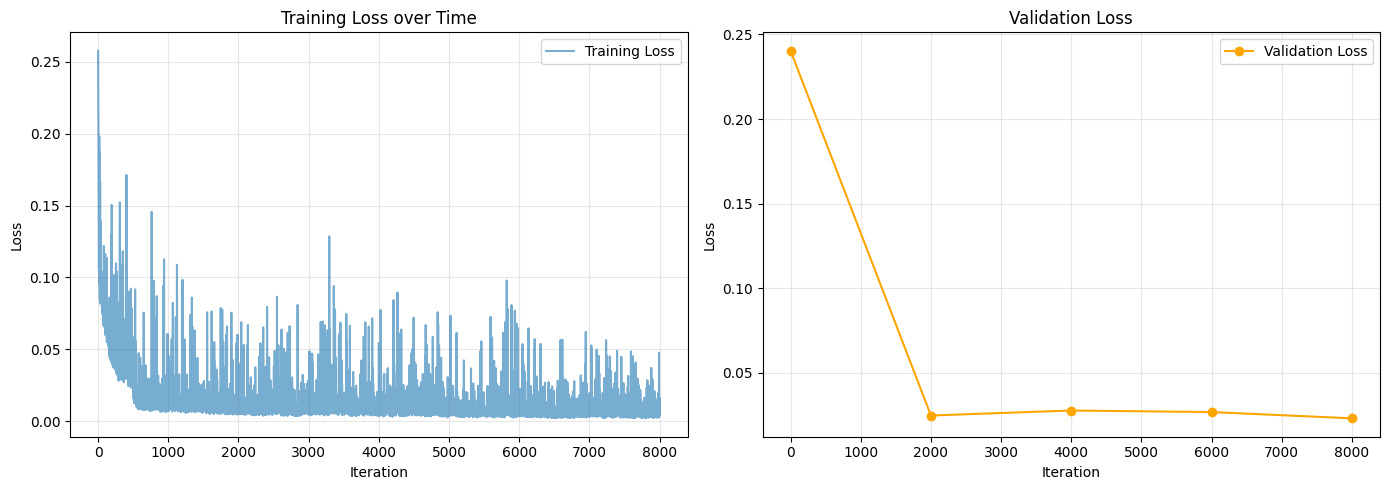

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, alpha=0.6, label='Training Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

valid_iterations = [i * display_rate for i in range(len(valid_losses))]
ax2.plot(valid_iterations, valid_losses, 'o-', label='Validation Loss', color='orange')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(LOG_PATH + '/image/loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Training Process and Results

The model trains for 8,000 iterations with validation every 2,000 steps. It uses weighted MSE loss that emphasizes robot pixels more than background.

**Training Details:**
- Batch size: 1 (full image at a time)
- Center cropping for first 500 iterations (focus on robot center)
- Early stopping with patience threshold
- Learning rate scheduling

**Performance:**
The loss curves show steady improvement, suggesting the model is learning. But without seeing the actual loss values or final performance metrics, it's hard to know if this is good enough.

**Critical Analysis:**
8,000 iterations seems like a lot, but with such a small dataset (1,600 training samples), the model might be overfitting. The center cropping strategy suggests the model struggles with the full image initially. 

The weighted loss is interesting - it prioritizes getting the robot shape right over background accuracy. But is this the right approach? Maybe the background predictions are also important for understanding spatial context.

Most importantly, how well does this actually work? The notebook shows predictions but doesn't quantify accuracy. Can the model really predict 3D occupancy from joint angles alone?

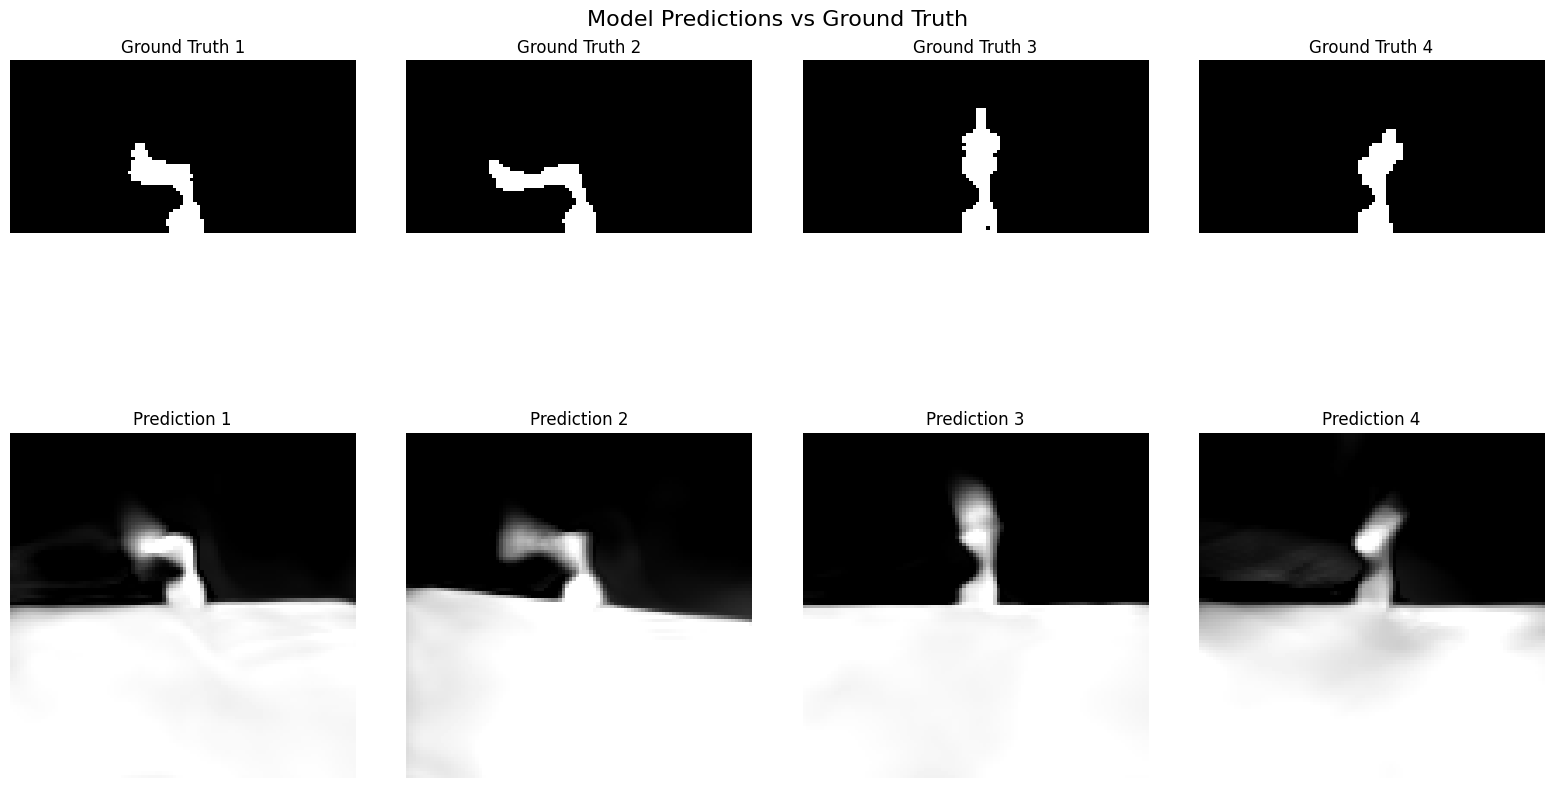

In [ ]:
model.eval()
num_samples_to_show = 4

fig, axes = plt.subplots(2, num_samples_to_show, figsize=(16, 8))

with torch.no_grad():
    for idx in range(num_samples_to_show):
        test_idx = idx * (valid_amount // num_samples_to_show)
        angle = testing_angles[test_idx]
        img_label = testing_img[test_idx]

        outputs = model_forward(rays_o, rays_d, near, far, model,
                               chunksize=chunksize, arm_angle=angle, DOF=DOF, output_flag=different_arch)

        rgb_predicted = outputs['rgb_map']

        gt_img = img_label.cpu().numpy()
        pred_img = rgb_predicted.reshape([height, width, 1]).detach().cpu().numpy()
        pred_img = np.clip(pred_img, 0, 1)

        axes[0, idx].imshow(gt_img, cmap='gray')
        axes[0, idx].set_title(f'Ground Truth {idx+1}')
        axes[0, idx].axis('off')

        axes[1, idx].imshow(pred_img, cmap='gray')
        axes[1, idx].set_title(f'Prediction {idx+1}')
        axes[1, idx].axis('off')

plt.suptitle('Model Predictions vs Ground Truth', fontsize=16)
plt.tight_layout()
plt.savefig(LOG_PATH + '/image/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Overall Assessment and Limitations

This notebook implements an interesting approach to robot self-modeling using NeRF principles, but there are several fundamental issues that need addressing.

**What Works:**
- The virtual frame transformation is a clever way to incorporate kinematic priors
- The split encoder design separates coordinate and joint processing
- Training converges and produces reasonable-looking predictions

**Major Limitations:**
1. **Data Quality**: Only 2,000 samples from one fixed viewpoint is insufficient for robust 3D learning
2. **Evaluation**: The notebook shows qualitative results but no quantitative metrics (IoU, accuracy, etc.)
3. **Generalization**: Trained on synthetic PyBullet data - unclear if it works on real robots
4. **Computational Cost**: Volume rendering is expensive for real-time robot control
5. **Viewpoint Limitation**: Model only learns from one camera angle

**Critical Questions:**
- Is the complexity of FFKSM justified compared to simpler approaches?
- Does the virtual frame actually help, or just add unnecessary complexity?
- Can this scale to real robots with multiple cameras and complex geometries?
- Is occupancy prediction the right representation for robot control?

The paper claims this enables robots to "build simulations of themselves," but this implementation seems more like a proof-of-concept than a practical system. Real robot self-modeling would need much more diverse data and better evaluation metrics. Additionally while NeRF works for offline visualization, its computational cost (<30 FPS) makes it unsuitable for the 1kHz real-time control loops required for this robot, compared to direct decoders.